---
# HHL with TensorNetworks

In this notebook we will build the HHL with tensor networks and execute it through matrix and tensor contraction in PyTorch.

We use qudit functions and formalism. Everything is collected in the paper.

We solve:
$$A\vec{x}=\vec{b}$$

In all processes normalization is performed in the last step.


Original paper: "Solving Systems of Linear Equations: HHL from a Tensor Networks Perspective"

Authors: Alejandro Mata Ali, Iñigo Perez Delgado, Marina Ristol Roura, 
         Aitor Moreno Fdez. de Leceta, Sebastián V. Romero
         
Year: 2025

arXiv: https://arxiv.org/abs/2309.05290

This implementation follows the tensor network approach described in the paper,
which provides an efficient way to simulate quantum algorithms classically
through tensor contractions and matrix operations.

python==3.12.10

Required packages:
- torch                   2.7.1
- qiskit                  2.1.0
- qiskit-aer              0.17.1
- qiskit-ibm-runtime      0.40.1
- scipy                   1.16.0

In [1]:
import torch

import numpy as np
from  scipy.linalg import expm

import matplotlib.pyplot as plt
from matplotlib import rcParams

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import phase_estimation, UnitaryGate, RYGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

rcParams.update( {'xtick.labelsize': 25, 'ytick.labelsize': 25, 'font.size': 20} )

---
# Functions for nodes.


These functions will create the matrices and tensors that we will contract.

## Quantum Fourier Transform (QFT)

This will be the matrix representation of the QFT operator.

The QFT matrix is defined as:
$$\frac{1}{\sqrt{m}}\sum_{x, y=0}^{m-1}e^{2\pi i \frac{xy}{m}}|x\rangle\langle y|$$

Its inverse (IQFT) is given by:
$$\frac{1}{\sqrt{m}}\sum_{x, y=0}^{m-1}e^{-2\pi i \frac{xy}{m}}|x\rangle\langle y|$$

The QFT transforms computational basis states to the Fourier basis, which is crucial
for quantum phase estimation and many other quantum algorithms.

In [2]:
def qft_op(n_eigen: int, sign: int) -> torch.Tensor:
    """
    Creates a Quantum Fourier Transform (QFT) matrix or its inverse.
    
    This function constructs the QFT matrix using the formula:
    QFT = (1/√m) * Σ_{x,y=0}^{m-1} exp(2πi * xy/m) |x⟩⟨y|
    
    For inverse QFT, the sign is negative: exp(-2πi * xy/m)
    
    Parameters:
    -----------
    n_eigen : int
        Size of the QFT matrix (n_eigen x n_eigen).
    sign : int
        Sign for the phase factor: +1 for QFT, -1 for inverse QFT.
    
    Returns:
    --------
    torch.Tensor
        The QFT matrix (normalized by 1/√n_eigen factor).
    
    Notes:
    ------
    - The matrix is constructed using a recurrence relation for efficiency
    - The result is normalized with the 1/√n_eigen prefactor
    """
    matrix = torch.ones((n_eigen, n_eigen), dtype=torch.complex128)
    # Phase factor for the QFT: 2πi/n_eigen (positive) or -2πi/n_eigen (negative)
    angle = 1j * sign * 2.0 * np.pi / n_eigen
    
    # Initialize the first row with phase factors (matrix[0,0] = 1 already set)
    for j in range(1, n_eigen):
        matrix[1, j] = np.exp(angle * j)
    
    # Use recurrence relation: row[i] = row[i-1] * row[1] (element-wise)
    # This exploits the periodicity of the QFT matrix structure
    for i in range(2, n_eigen):
        matrix[i] = matrix[i-1] * matrix[1]

    return matrix / np.sqrt(n_eigen)

## Phase Kickback and inverter

Now we implement the Phase Kickback (PKB), which will apply U n times to obtain the 'decimal' n of the eigenvalue.
The inverse is obtained by giving the same Hermitian conjugate as input.

The inverter will take the amplitude of each of the possible values and divide it by the corresponding eigenvalue (with the prefactor by t).

In [3]:
def phase_kickback_op(b_vector:torch.Tensor, n_eigen:int, U_matrix: torch.Tensor) -> torch.Tensor:
    """
    Function that creates the Phase KickBack tensor for QPE.
    
    This function computes U^0*b, U^1*b, U^2*b, ..., U^(n_eigen-1)*b where b is the input vector.
    The result is stored in a matrix where each row represents a different power of U applied to b.
    
    Parameters:
    -----------
    b_vector : torch.Tensor
        Input vector to be transformed.
    n_eigen : int
        Number of eigenvalues (determines the number of powers to compute).
    U_matrix : torch.Tensor
        Unitary matrix to be raised to powers.
    
    Returns:
    --------
    torch.Tensor
        Matrix where each row i contains U^i * b_vector.
    """
    # Multiply the previous by U
    n_elems = U_matrix.shape[0]
    phase_kick_matrix = torch.zeros((n_eigen, n_elems), dtype=torch.complex128)
    phase_kick_matrix[0] = b_vector.clone()
    ans = b_vector.clone()  # Clone to avoid modifying the original

    for i in range(1, n_eigen):
        ans = torch.matmul(U_matrix, ans)
        phase_kick_matrix[i] = ans
    return phase_kick_matrix

def phase_kickback_op_inv(n_eigen:int, U_matrix: torch.Tensor) -> torch.Tensor:
    """
    Function that creates the inverse Phase KickBack tensor for QPE.
    
    This function computes U^0, U^1, U^2, ..., U^(n_eigen-1) where U is the unitary matrix.
    The result is stored in a 3D tensor where each slice represents a different power of U.
    
    Parameters:
    -----------
    n_eigen : int
        Number of eigenvalues (determines the number of powers to compute).
    U_matrix : torch.Tensor
        Unitary matrix to be raised to powers.
    
    Returns:
    --------
    torch.Tensor
        3D tensor where each slice i contains U^i.
    """
    # Multiply the previous by U
    n_elems = U_matrix.shape[0]
    phase_kick_tensor = torch.zeros((n_eigen, n_elems, n_elems), dtype=torch.complex128)
    phase_kick_tensor[0] = torch.eye(n_elems, dtype=torch.complex128)
    ans = phase_kick_tensor[0].clone()  # Clone to avoid modifying the original

    for i in range(1, n_eigen):
        ans = torch.matmul(ans, U_matrix)
        phase_kick_tensor[i] = ans
    return phase_kick_tensor

def inversor(n_eigen: int, t: float) -> torch.Tensor:
    """
    Function that creates the inversion matrix.
    
    This function creates a diagonal matrix with eigenvalues 1/i and -1/i,
    where i ranges from 1 to n_eigen//2. This is used for eigenvalue inversion
    in the HHL algorithm.
    
    Parameters:
    -----------
    n_eigen : int
        Size of the square matrix to create.
    t : float
        Exponential scaling factor.
    
    Returns:
    --------
    torch.Tensor
        The matrix with inversion values on the diagonal.
    """
    matrix = torch.zeros((n_eigen, n_eigen), dtype=torch.complex128)
    # Assign the values
    for i in range(1, (n_eigen // 2 + 1)):  # The +1 is for the extra in case n_eigen is even.
        matrix[-i, -i] = -1 / i  # Negative eigenvalues
        matrix[i, i] = 1 / i     # Positive eigenvalues

    return matrix * t / n_eigen

## Constructor function.

This function joins all the elements and returns the result, already scaled.

In [4]:
def tracer(W_matrix: torch.Tensor, U_matrix: torch.Tensor):
    '''
    This function performs the trace after the last product.
    Parameters:
    - W_matrix, torch.Tensor: W matrix.
    - U_matrix, torch.Tensor: inverse U tensor.
    Returns:
    - C_matrix, torch.Tensor: tensor with unscaled solution.
    '''
    C_matrix = torch.tensordot(W_matrix, U_matrix, dims=[[0,1], [0,1]])  # C_k = W_ij U^(-1)_ijk

    return C_matrix
#-----------------------------------------------------------------
def tensornetwork_HHL(num_eigen: int, t: float, b_vector: torch.Tensor, A_matrix: torch.Tensor):
    '''
    Function that generates tensors and contracts them.
    Parameters:
    - num_eigen, int: number of eigenvalues.
    - t, float: exponential scaling factor.
    - b_vector, torch.Tensor: vector b.
    - A_matrix, torch.Tensor: matrix A.
    Returns:
    - solution, torch.Tensor: the solution x
    '''
    # Calculate dimensions
    n_elements   = len(b_vector)
    # Calculate complex exponentials
    U_matrix_inv = torch.matrix_exp(-(2j*np.pi*t/num_eigen)*A_matrix)
    U_matrix     = torch.conj(U_matrix_inv).T  # its transpose

    # Product PKB-QFT_inverse-inversor-QFT, careful with
    # indices, done to avoid transpositions
    W_matrix = torch.matmul( qft_op(num_eigen, sign=1),     \
                   torch.matmul( inversor(num_eigen, t), \
                        torch.matmul(qft_op(num_eigen, sign=-1), \
                            phase_kickback_op(b_vector, num_eigen, U_matrix)) ) )
    # Rescaled result
    return tracer(W_matrix, phase_kickback_op_inv(num_eigen, U_matrix_inv)).real


---
# Test

## Matrices generation

In [5]:
def problem_OAF(param, scaling = True):
    '''
    Function that creates matrix A and vector b for the forced harmonic oscillator.
    Params:
    k = spring constant
    m = mass of the spring
    nu = force frequency
    C = external force intensity
    x0 = left boundary
    xq = right boundary
    dt = time interval
    steps = number of time intervals

    - scaling, bool: If True, rescale the problem so that the matrix has norm 1.

    Output:
    - force, torch.Tensor: vector b
    - matrix, torch.Tensor: matrix A'''

    k, m, nu, C = param['k'], param['m'], param['nu'], param['C']
    x0, xq, dt, steps = param['x0'], param['xq'], param['dt'], param['steps']

    # Matrix
    matrix = torch.eye(steps, dtype=torch.complex128) * (-2 + k/m * dt**2)  # Diagonal
    for i in range(steps-1):  # Non-diagonal
        matrix[i,i+1] = 1  # Upper diagonal
        matrix[i+1,i] = 1  # Lower diagonal

    # External force
    force = torch.tensor( [C*np.sin(np.pi*nu*dt)-x0/dt**2] + \
                    [ C*np.sin(np.pi*nu*(i+1)*dt) for i in range(1, steps-1)] + \
                    [C*np.sin(np.pi*nu*steps*dt)-xq/dt**2], dtype=torch.complex128)

    if scaling == True:
        scale = torch.linalg.norm(matrix)
        matrix /= scale
        force /= scale

    return force, matrix

In [6]:
def problem_OAA(param, scaling = True):
    '''
    Function that creates matrix A and vector b for the forced and damped harmonic oscillator.
    Params:
    k = spring constant
    m = mass of the spring
    nu = force frequency
    gamma = damping
    C = external force intensity
    x0 = left boundary
    xq = right boundary
    dt = time interval
    steps = number of time intervals

    - scaling, bool: If True, rescale the problem so that the matrix has norm 1.'''

    k, m, nu, C, gamma = param['k'], param['m'], param['nu'], param['C'], param['gamma']
    x0, xq, dt, steps = param['x0'], param['xq'], param['dt'], param['steps']

    # Matrix
    matrix = torch.eye(steps, dtype=torch.complex128) * (-2 + k/m * dt**2)  # Diagonal
    for i in range(steps-1):  # Non-diagonal
        matrix[i,i+1] = 1+gamma*dt/2
        matrix[i+1,i] = 1-gamma*dt/2

    # External force
    force = torch.tensor( [C*np.sin(np.pi*nu*dt)-(1-gamma*dt/2)*x0/dt**2] + \
                    [ C*np.sin(np.pi*nu*(i+1)*dt) for i in range(1, steps-1)] + \
                    [C*np.sin(np.pi*nu*steps*dt)-(1+gamma*dt/2)*xq/dt**2] )

    if scaling == True:
        scale = torch.linalg.norm(matrix)
        matrix /= scale
        force /= scale

    new_matrix = torch.zeros((2*steps, 2*steps), dtype=torch.complex128)
    new_matrix[:steps, steps:] = matrix
    new_matrix[steps:, :steps] = matrix.T

    new_force = torch.zeros(2*steps, dtype=torch.complex128)
    new_force[:steps] = force
    return new_force, new_matrix, force, matrix

In [7]:
def problem_C2D(param, scaling = True):
    '''
    Function that creates matrix A and vector b for the 2D convection-diffusion problem.
    Params:
    k = diffusion coefficient
    u1x, u2x = boundary conditions in x direction
    u1y, u2y = boundary conditions in y direction
    dxy = spatial discretization step
    nx, ny = number of grid points in x and y directions

    - scaling, bool: If True, rescale the problem so that the matrix has norm 1.'''

    k, u1x, u2x, u1y, u2y = param['k'], param['u1x'], param['u2x'], param['u1y'], param['u2y']
    dxy, nx, ny = param['dxy'], param['nx'], param['ny']

    # Matrix
    matrix = torch.eye(nx*ny, dtype=torch.complex128) * (-4)  # Diagonal
    
    # First row (i=0)
    matrix[0,ny] = 1
    matrix[0,1] = 1
    for j in range(1, ny-1):  # Non-diagonal
        matrix[j,ny+j] = 1
        matrix[j,j+1] = 1
        matrix[j,j-1] = 1
    matrix[ny-1,ny+ny-1] = 1
    matrix[ny-1,ny-1-1] = 1

    for i in range(1, nx-1):
        # First column (j=0)
        matrix[i*ny,(i+1)*ny] = 1
        matrix[i*ny,(i-1)*ny] = 1
        matrix[i*ny,i*ny+1] = 1
        for j in range(1, ny-1):  # Non-diagonal
            matrix[i*ny+j,(i+1)*ny+j] = 1
            matrix[i*ny+j,(i-1)*ny+j] = 1
            matrix[i*ny+j,i*ny+j+1] = 1
            matrix[i*ny+j,i*ny+j-1] = 1
        # Last column (j=ny-1)
        matrix[i*ny+ny-1,(i+1)*ny+ny-1] = 1
        matrix[i*ny+ny-1,(i-1)*ny+ny-1] = 1
        matrix[i*ny+ny-1,i*ny+ny-1-1] = 1

    # Last row (i=nx-1)
    matrix[(nx-1)*ny,((nx-1)-1)*ny] = 1
    matrix[(nx-1)*ny,(nx-1)*ny+1] = 1
    for j in range(1, ny-1):  # Non-diagonal
        matrix[(nx-1)*ny+j,((nx-1)-1)*ny+j] = 1
        matrix[(nx-1)*ny+j,(nx-1)*ny+j+1] = 1
        matrix[(nx-1)*ny+j,(nx-1)*ny+j-1] = 1
    matrix[(nx-1)*ny+ny-1,((nx-1)-1)*ny+ny-1] = 1
    matrix[(nx-1)*ny+ny-1,(nx-1)*ny+ny-1-1] = 1

    # External force
    fuerza = torch.zeros((nx, ny), dtype=torch.complex128)
    fuerza[0,0] = u1x*k/dxy**2 + u1y*k/dxy**2
    for j in range(1, ny-1):
        fuerza[0,j] = u1x*k/dxy**2
    fuerza[0, ny-1] = u1x*k/dxy**2 + u2y*k/dxy**2

    for i in range(1, nx-1):
        fuerza[i,0] = u1y*k/dxy**2
        for j in range(1, ny-1):
            fuerza[i,j] = 10*np.sin(2*np.pi*i*j/np.sqrt(nx*ny))
        fuerza[i, ny-1] = u2y*k/dxy**2

    fuerza[nx-1,0] = u2x*k/dxy**2 + u1y*k/dxy**2
    for j in range(1, ny-1):
        fuerza[nx-1,j] = u2x*k/dxy**2
    fuerza[nx-1, ny-1] = u2x*k/dxy**2 + u2y*k/dxy**2

    fuerza = -fuerza.flatten()*dxy**2/k

    if scaling == True:
        scalado = torch.linalg.norm(matrix)
        matrix /= scalado
        fuerza /= scalado

    return fuerza, matrix

---
## Harmonic Oscillator


We are going to solve the differential equation

$$\frac{d^2x}{dt^2} + \frac{k}{m}x = C \sin(\nu t)$$

Program values:

k = spring constant

m = mass of the spring

nu = frequency of the force

C = external force intensity

x0 = left boundary

xq = right boundary

dt = time interval

steps = number of time intervals

Resolution parameters:

m = number of possible eigenvalues

t = eigenvalue precision

matrix = discretization scheme

force = independent term


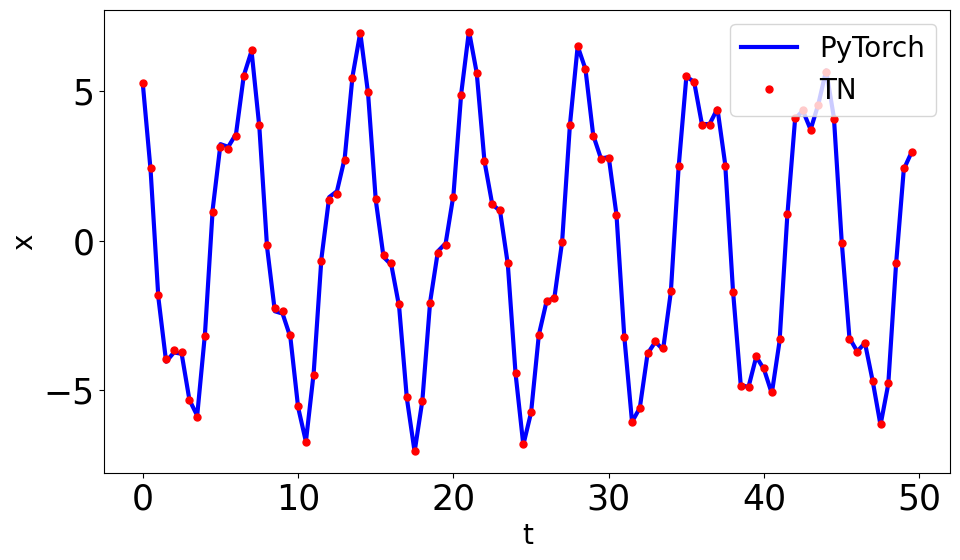

In [8]:
#Physical parameters
params_OAF = {
    'k'     : 5,
    'm'     : 7,
    'nu'    : 3.14,
    'C'     : 9.,
    'x0'    : 5,
    'xq'    : 3,
    'dt'    : 0.5,
    'steps' : 100
    }

#Resolution parameters
num_eigen = 2000
t = 6000

#-------------------------------------------------------------------------
#Create matrix and vector
force, matrix = problem_OAF(params_OAF, scaling=True)

#Results
tn_result = tensornetwork_HHL(num_eigen, t, force, matrix)*params_OAF['dt']**2
#Real result
actual_result = torch.linalg.inv(matrix) @ force
actual_result = actual_result.real * params_OAF['dt']**2

#Plot
plt.figure('Forced oscillator', figsize=(10,6))
plt.plot(np.arange(params_OAF['steps'])*params_OAF['dt'], actual_result, 'b-', linewidth=3,  label='PyTorch')
plt.plot(np.arange(params_OAF['steps'])*params_OAF['dt'], tn_result, 'r.', markersize=10, label='TN')

plt.xlabel('t'); plt.ylabel('x')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('OAF.pdf')
plt.show()

### Precision and execution time checks

In [9]:
#We check the mean squared error.
error1 = torch.sqrt(torch.sum((force.real*params_OAF['dt']**2 - torch.matmul(matrix.real, tn_result))**2))/params_OAF['steps']
errorreal = torch.sqrt(torch.sum((force.real*params_OAF['dt']**2 - torch.matmul(matrix.real, actual_result))**2))/params_OAF['steps']

print('Error tensor network: ', error1)
print('Error linalg:         ', errorreal)

Error tensor network:  tensor(6.3748e-06, dtype=torch.float64)
Error linalg:          tensor(3.1373e-17, dtype=torch.float64)


In [10]:
%timeit tensornetwork_HHL(num_eigen, t, force, matrix)
%timeit (torch.linalg.inv(matrix) @ force).real

362 ms ± 4.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
257 μs ± 14 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


---
## Damped Oscillator



We will solve the differential equation

$$\frac{d^2x}{dt^2} + \gamma \frac{dx}{dt} + \frac{k}{m}x = C \sin(\nu t)$$

Program values:

k = spring constant

m_spring = spring mass

nu = force frequency

gamma = damping

C = external force intensity

x0 = left boundary

xq = right boundary

dt = time interval

steps = number of time intervals

Resolution parameters:

m = number of possible eigenvalues

t = eigenvalue precision

matrix = discretization scheme

force = independent term

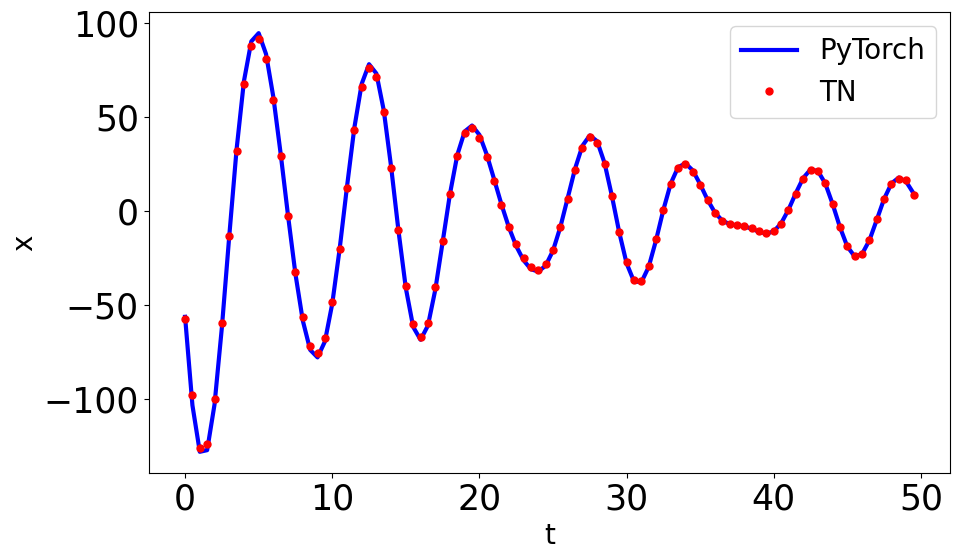

In [11]:
#Physical parameters
params_OAA = {
    'k'     : 5,
    'm'     : 7,
    'nu'    : 0.4,
    'C'     : 9,
    'x0'    : 5,
    'xq'    : 2,
    'dt'    : 0.5,
    'steps' : 100,
    'gamma' : 0.1
    }

#Resolution parameters
num_eigen = 2000
t = int(1.1e4)  # Convert to int to fix type error

#--------------------------------------------------------------
#Create matrix and vector
force, matrix, old_force, old_matrix = problem_OAA(params_OAA, scaling=True)
#Results
tn_result = tensornetwork_HHL(num_eigen, t, force, matrix)*params_OAA['dt']**2
#Real result
actual_result = torch.matmul(torch.linalg.inv(old_matrix.real), old_force.real)*params_OAA['dt']**2

#Plot
plt.figure('Forced Oscillator', figsize=(10,6))
plt.plot(np.arange(params_OAA['steps'])*params_OAA['dt'], actual_result, 'b-', linewidth=3,  label='PyTorch')
plt.plot(np.arange(params_OAA['steps'])*params_OAA['dt'], tn_result[params_OAA['steps']:], 'r.', markersize=10, label='TN')

plt.xlabel('t'); plt.ylabel('x')
plt.legend(loc='upper right'); plt.tight_layout()
plt.savefig('OAA.pdf')
plt.show()

### Precision and execution time checks

In [12]:
#We check the mean squared error.
error1 = torch.sqrt(torch.sum((old_force.real*params_OAA['dt']**2 - torch.matmul(old_matrix.real, tn_result[params_OAA['steps']:]))**2))/params_OAA['steps']
errorreal = torch.sqrt(torch.sum((old_force.real*params_OAA['dt']**2 - torch.matmul(old_matrix.real, actual_result))**2))/params_OAA['steps']

print('Error tensor network: ', error1)
print('Error linalg: ', errorreal)

Error tensor network:  tensor(0.0057, dtype=torch.float64)
Error linalg:  tensor(8.8653e-17, dtype=torch.float64)


In [13]:
%timeit tensornetwork_HHL(num_eigen, t, force, matrix)
%timeit (torch.linalg.inv(old_matrix.real) @ old_force.real).real

1.24 s ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
179 μs ± 3.47 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


---
## Heat Equation

We solve the heat equation:

$$\kappa\left(\frac{d^2u}{dx^2} + \frac{d^2u}{dy^2} \right) = -S(x,y);\quad u_{x1} = u(0, y); \quad u_{x2} = u(L_x, y); \quad u_y = u(x, 0); \quad u_{y2} = u(x, L_y)$$

with $S(x,y)= 10 \sin(2\pi \frac{xy}{L_x L_y})$.

Discretization:
$u_{j+1,k} + u_{j-1,k} + u_{j,k+1} + u_{j,k-1} - 4u_{jk} = -(\Delta x)^2 S_{jk}$

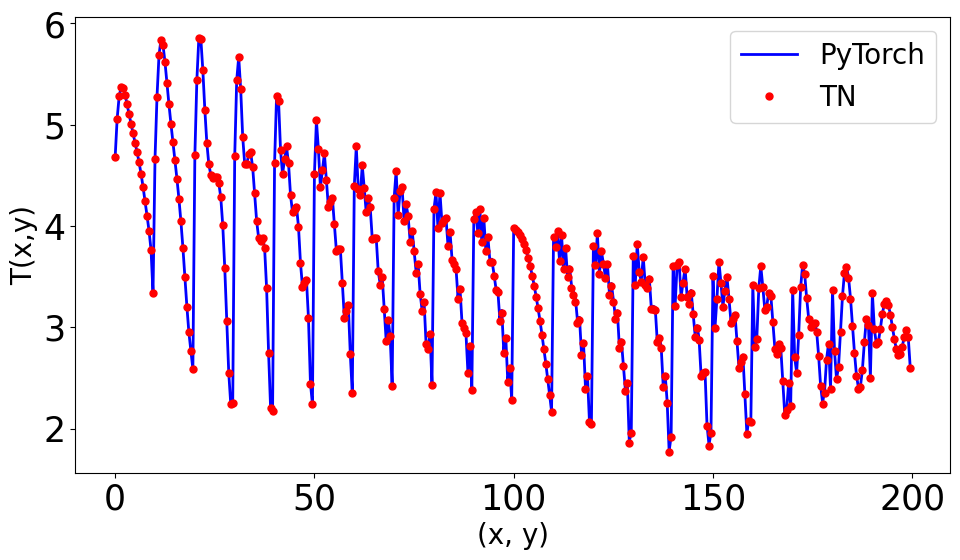

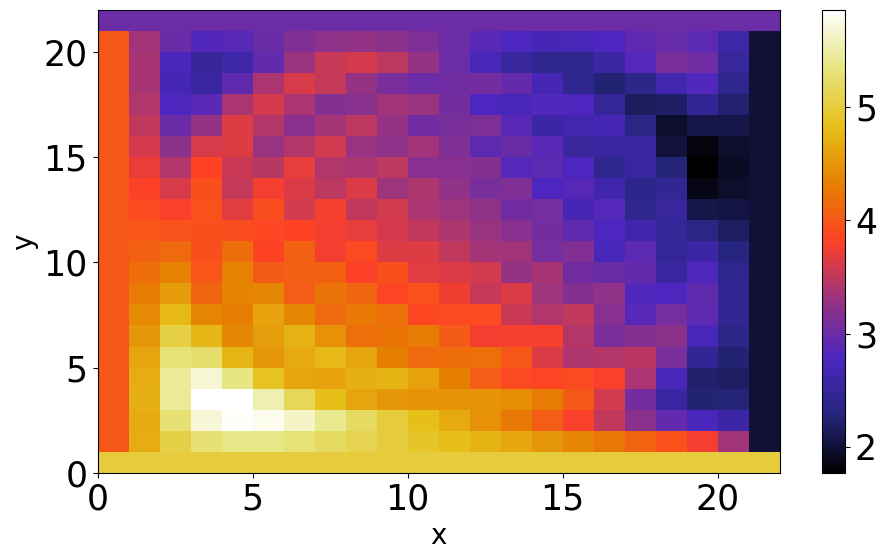

In [14]:
#Physical parameters
params_C2D = {
    'k'     : 3,
    'u1x'    : 5,
    'u2x'    : 3,
    'u1y'   : 4,
    'u2y'   : 2,
    'dxy'    : 0.5,
    'nx'    : 20,
    'ny'    : 20
    }

#Resolution parameters
num_eigen = 2000
t = 100

#---------------------------------------------------------------------------
#Create matrix and vector
force, matrix = problem_C2D(params_C2D, scaling=False)
#Results
tn_result = tensornetwork_HHL(num_eigen, t, force, matrix)
#Real result
actual_result = torch.linalg.inv(matrix.real) @ force.real

#Plot
plt.figure('Forced oscillator', figsize=(10, 6))
plt.plot(np.arange(params_C2D['nx']*params_C2D['ny'])*params_C2D['dxy'], actual_result, 'b-', linewidth=2,  label='PyTorch')
plt.plot(np.arange(params_C2D['nx']*params_C2D['ny'])*params_C2D['dxy'], tn_result, 'r.', markersize=10, label='TN')

plt.xlabel('(x, y)'); plt.ylabel('T(x,y)')
plt.legend(loc='upper right'); plt.tight_layout()
plt.savefig('C2D.pdf')
plt.show()

x = np.arange(params_C2D['nx'])*params_C2D['dxy']
y = np.arange(params_C2D['ny'])*params_C2D['dxy']
X, Y = np.meshgrid(x, y)

new_result = list(tn_result.reshape(params_C2D['nx'], params_C2D['ny']))

new_result = [[params_C2D['u1x'],]*(params_C2D['nx']+2)] + new_result + [[params_C2D['u2x'],]*(params_C2D['nx']+2)]
for i in range(1,params_C2D['nx']+1):
    new_result[i] = [params_C2D['u1y']] + list(new_result[i]) + [params_C2D['u2y']]

plt.figure('Heat equation', figsize=(10, 6))
plt.pcolormesh(new_result, cmap = "CMRmap");
plt.colorbar()
plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout()
plt.savefig('C2D_2D.pdf')
plt.show()

### Precision and execution time checks

In [15]:
#Check the mean squared error.
error1 = torch.sqrt(torch.sum((force.real - torch.matmul(matrix.real, tn_result))**2))/(params_C2D['nx']*params_C2D['ny'])
errorreal = torch.sqrt(torch.sum((force.real - torch.matmul(matrix.real, actual_result))**2))/(params_C2D['nx']*params_C2D['ny'])

print('Tensor network error: ', error1)
print('Linalg error: ', errorreal)

Tensor network error:  tensor(9.9555e-05, dtype=torch.float64)
Linalg error:  tensor(5.2211e-16, dtype=torch.float64)


In [16]:
%timeit tensornetwork_HHL(num_eigen, t, force, matrix)
%timeit torch.linalg.inv(matrix.real) @ force.real

8.18 s ± 5.66 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.2 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


---
# HHL

This is the original HHL, implemented in Qiskit. The circuit is

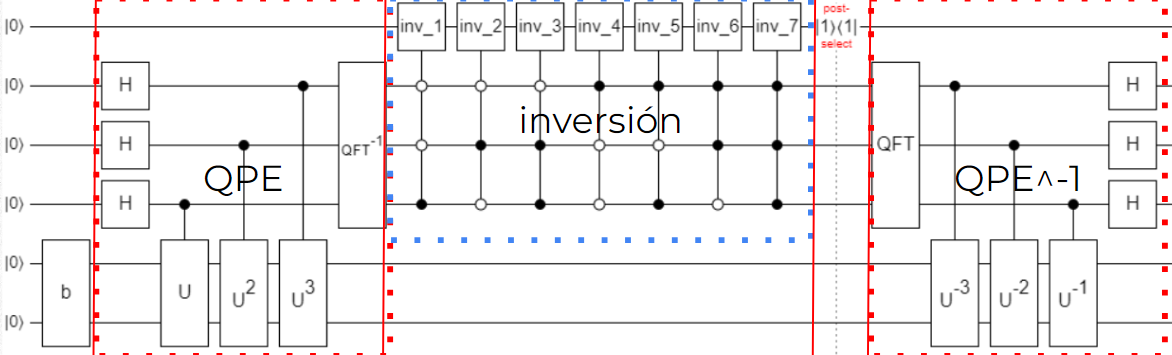

---
## Quantum Circuit

For the quantum circuit implementation, we require the input vector b and the coefficient matrix A. The circuit parameters include the number of ancilla qubits m for quantum phase estimation (QPE), the time evolution parameter t, and the rotation scaling factor C. This implementation is specifically designed for Hermitian matrices, as the non-Hermitian case requires additional considerations.

In [17]:
def HHL_circuit(n_ancillas: int, b_vector: torch.Tensor, A_matrix: torch.Tensor, t: float, C: float):
    """
    Constructs an HHL (Harrow-Hassidim-Lloyd) quantum circuit for solving linear systems Ax = b.
    
    This function implements the quantum algorithm for solving systems of linear equations
    using quantum phase estimation and controlled rotations. The circuit consists of:
    1. State preparation with input vector b
    2. Quantum phase estimation to extract eigenvalues
    3. Controlled rotations based on eigenvalue estimates
    4. Inverse phase estimation
    
    Args:
        n_ancillas (int): Number of ancilla qubits for phase estimation (determines precision)
        b_vector (torch.Tensor): Input vector b of the linear system Ax = b
        A_matrix (torch.Tensor): Hermitian matrix A of the linear system (must be square)
        t (float): Time parameter for unitary evolution operator U = exp(iAt)
        C (float): Scaling parameter for rotation angles (typically C ≤ min eigenvalue)
    
    Returns:
        QuantumCircuit: Complete HHL quantum circuit ready for execution
        
    Note:
        The circuit automatically pads inputs to power-of-2 dimensions for efficient
        quantum implementation. The solution vector x is encoded in the final state
        of the quantum register.
    """
    # Determine the number of qubits needed for the state
    n_state_qubits = int(np.ceil(np.log2(len(b_vector))))
    # Pad vector b to power of 2 dimensions
    b_padded = np.concatenate([b_vector.real.numpy(), np.zeros(2**n_state_qubits - len(b_vector))])
    
    # Pad matrix A to power of 2 dimensions with identity matrix
    A_padded = np.eye(2**n_state_qubits)
    A_padded[:A_matrix.shape[0], :A_matrix.shape[1]] = A_matrix.real.numpy()
    
    # Create unitary evolution operator
    U_matrix = expm(1j * A_padded * t)
    U_gate = UnitaryGate(U_matrix, label='U')
    
    # Define quantum registers
    ancilla_reg = QuantumRegister(1, 'Anc')
    clock_reg = QuantumRegister(n_ancillas, 'Clock')
    state_reg = QuantumRegister(n_state_qubits, 'State')

    # Define the classical registers
    crAncilla = ClassicalRegister(1, name='canc')
    crClock = ClassicalRegister(n_ancillas, name='cClock')
    crState = ClassicalRegister(n_state_qubits, name='cState')
    
    # Create quantum circuit
    q_circ = QuantumCircuit(ancilla_reg, clock_reg, state_reg, crAncilla, crClock, crState, name='HHL')
    
    # Initialize state register with normalized input vector
    q_circ.initialize(b_padded, state_reg, normalize=True)
    q_circ.barrier()
    
    # Apply Quantum Phase Estimation
    q_circ.append(phase_estimation(n_ancillas, U_gate), clock_reg[:] + state_reg[:])
    q_circ.barrier()

    # Apply controlled rotation gates for positive eigenvalues
    for lambda_i in range(1, 2**n_ancillas // 2):
        # Calculate rotation angle based on eigenvalue
        theta = 2 * np.arcsin(C / lambda_i)
        
        # Convert eigenvalue index to binary representation
        binary_str = bin(lambda_i)[2:]
        binary_str = ('0' * (n_ancillas - len(binary_str)) + binary_str)  # Pad with leading zeros
        
        # Apply X gates to create appropriate control pattern
        for j, bit in enumerate(binary_str):
            if bit == '0':
                q_circ.x(j + 1)  # +1 to account for ancilla register
        
        # Apply controlled rotation gate
        q_circ.append(RYGate(theta).control(n_ancillas), clock_reg[:] + ancilla_reg[:])
        
        # Undo X gates to restore original state
        for j, bit in enumerate(binary_str):
            if bit == '0':
                q_circ.x(j + 1)  # +1 to account for ancilla register

    for lambda_i in range(2**n_ancillas // 2, 2**n_ancillas):  # Negative eigenvalues
        # Calculate rotation angle based on eigenvalue
        theta = 2 * np.arcsin(-C / (2**n_ancillas - lambda_i))
        
        # Convert eigenvalue index to binary representation
        binary_str = bin(lambda_i)[2:]
        binary_str = ('0' * (n_ancillas - len(binary_str)) + binary_str)  # Pad with leading zeros
        
        # Apply X gates to create appropriate control pattern
        for j, bit in enumerate(binary_str):
            if bit == '0':
                q_circ.x(j + 1)  # +1 to account for ancilla register
        
        # Apply controlled rotation gate
        q_circ.append(RYGate(theta).control(n_ancillas), clock_reg[:] + ancilla_reg[:])
        
        # Undo X gates to restore original state
        for j, bit in enumerate(binary_str):
            if bit == '0':
                q_circ.x(j + 1)  # +1 to account for ancilla register

    q_circ.barrier()

    # Inverse QPE
    q_circ.append(phase_estimation(n_ancillas, U_gate).inverse(), clock_reg[:] + state_reg[:])

    q_circ.barrier()
    q_circ.measure(ancilla_reg, crAncilla)
    q_circ.measure(clock_reg, crClock)
    q_circ.measure(state_reg, crState)

    # We need to decompose QPE to avoid errors
    qc_desc = q_circ.decompose(['QPE', 'QPE_dg'], reps=2)

    # display(q_circ.draw('mpl'))

    return qc_desc

## Executing the HHL Circuit


This section demonstrates how to execute the HHL quantum circuit on a quantum backend.
The circuit implements the HHL algorithm to solve linear systems of equations.



In [18]:
rcParams.update( {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'font.size': 10} )

In [19]:
def original_HHL_solver(n_ancillas: int, b_vector: torch.Tensor, A_matrix: torch.Tensor, t: float, C: float,
                        n_shots: int, backend):
    """
    Execute the HHL algorithm on a quantum backend.
    
    Args:
        n_ancillas: Number of ancilla qubits for phase estimation
        b_vector: Input vector b in the equation Ax = b
        A_matrix: Hermitian matrix A in the equation Ax = b
        t: Time parameter for the evolution
        C: Normalization constant
        n_shots: Number of shots for the quantum circuit execution
        backend: Quantum backend to run the circuit on
        
    Returns:
        torch.Tensor: Vector of probabilities representing the solution
    """
    
    # Create the HHL quantum circuit
    qc_circ = HHL_circuit(n_ancillas, b_vector, A_matrix, t, C)

    # Transpile the circuit for the target backend
    qc_transpiled = transpile(qc_circ, backend)

    # Execute the circuit with specified number of shots
    job = backend.run(qc_transpiled, shots=n_shots)
    
    # Get measurement results
    counts = job.result().get_counts()
    
    # Calculate number of state qubits
    n_state = int(np.ceil(np.log2(len(b_vector))))

    # Extract successful measurements (ancilla qubit = '1')
    success_counts = {key[:-2]: counts[key] for key in counts if key[-1] == '1'}
    
    # Initialize probability dictionary for all possible states
    x_state = {}
    for i in range(2**n_state): # Start by initializing the keys
        binary = bin(i)[2:]
        binary = '0'*(n_state-len(binary)) + binary
        x_state[binary] = 0

    for i in range(2**n_state): # Sum all that match
        binary = bin(i)[2:]
        binary = '0'*(n_state-len(binary)) + binary
        x_state[binary] += sum([ success_counts[key] for key in success_counts if key[:n_state] == binary ])
    
    # Normalize probabilities
    total_sum = sum(x_state.values())
    if total_sum > 0:
        x_state = {key: value / total_sum for key, value in x_state.items()}

    # display(plot_histogram(x_state))

    # Convert x_state dictionary to a vector of probabilities
    probabilities = []
    for i in range(2**n_state):
        binary = bin(i)[2:]
        binary = '0'*(n_state-len(binary)) + binary
        probabilities.append(x_state[binary])
    probabilities = torch.tensor(probabilities, dtype=torch.float64)
    return probabilities

## Test

This section tests the original HHL implementation with a simple example to verify it works correctly.


In [20]:
num_anc = 5
t = 1
C_value = 1
b_vector = torch.tensor([1,2,-3,1], dtype=torch.complex128)
A_matrix = torch.tensor([[1,0,0,2],
              [0,1,0,0],
              [0,0,1,0],
              [2,0,0,1]], dtype=torch.complex128)

#Number of shots
n_shots = 100000

#Simulator
backend = AerSimulator()

probabilities = original_HHL_solver(num_anc, b_vector, A_matrix, t, C_value, n_shots, backend)

In [21]:
x_real = np.linalg.inv(A_matrix) @ b_vector
print('HHL probabilities we obtain:    ', probabilities)
print('Probabilities we should obtain: ', (x_real/np.linalg.norm(x_real)).real**2)# * n_shots)

HHL probabilities we obtain:     tensor([0.0078, 0.3138, 0.6679, 0.0105], dtype=torch.float64)
Probabilities we should obtain:  tensor([0.0084, 0.3025, 0.6807, 0.0084], dtype=torch.float64)


---
# TN HHL vs HHL

This section performs comprehensive testing of the tensor network HHL implementation against the original quantum HHL method and direct matrix inversion.

### Test Setup
- **Number of ancilla qubits**: 10 (determines precision of eigenvalue estimation)
- **Number of shots**: 100,000 (for quantum circuit sampling)
- **Backend**: AerSimulator (Qiskit's quantum simulator)
- **Time parameter**: t = 1 for all test cases
- **C value**: C = 1 for all test cases (scaling parameter)

### Test Procedure
For each randomly generated problem (matrix A and vector b):
1. **Tensor Network Method**: Solves using our tensor network implementation with rescaling factor for $t$ of 100
2. **Original HHL Method**: Solves using the quantum circuit implementation
3. **Direct Matrix Inversion**: Computes exact solution using classical matrix inversion (ground truth)

### Evaluation Metrics
- **RMSE (Root Mean Square Error)**: Measures accuracy between methods
- **Normalization**: Results are normalized and squared for fair comparison
- **Three comparisons**:
  - Tensor Network vs Direct Method
  - HHL vs Direct Method  
  - Tensor Network vs HHL

### Expected Outcomes
The tests will provide quantitative comparison of:
- Accuracy of tensor network approximation vs quantum implementation
- Performance relative to exact classical solution
- Consistency between different approaches to the same problem

## Problem Creation and Testing Setup

This section creates a comprehensive test suite for comparing tensor network HHL, 
quantum HHL, and direct matrix inversion methods.

### Test Parameters:
- **Matrix size**: 16x16 (4 qubits)
- **Number of test cases**: 20 randomly generated problems
- **Matrix type**: Sparse Hermitian matrices with controlled eigenvalue spectrum
- **Vector type**: Random normalized vectors

### Matrix Generation Strategy:
1. **Diagonal elements**: Random values in [-1, 1]
2. **Off-diagonal elements**: Sparse random connections (25% density)
3. **Hermitian structure**: Ensures real eigenvalues
4. **Eigenvalue normalization**: Scales matrix so largest eigenvalue < 1

### Quality Control:
- Deterministic generation using fixed seeds
- Proper normalization of input vectors
- Controlled eigenvalue spectrum for numerical stability
- Hermitian structure preservation for physical relevance



In [22]:
n_elements = 16
n_matrices = 20

seeds = np.arange(n_matrices)

In [23]:
b_vector = []
rmse_tn, rmse_hhl, rmse_tn_hhl = torch.zeros(n_matrices, dtype=torch.float16), torch.zeros(n_matrices, dtype=torch.float16), torch.zeros(n_matrices, dtype=torch.float16)

# Create sparse matrices with random values
A_matrix = [torch.zeros(n_elements, n_elements, dtype=torch.complex128) for _ in range(n_matrices)]

# Generate random matrices and vectors
for idx in range(n_matrices):
    torch.manual_seed(seeds[idx])
    
    # Create random b vector
    b_vector.append(torch.tensor(2*torch.rand(n_elements)-1, dtype=torch.complex128))
    b_vector[-1] /= torch.norm(b_vector[-1])
    
    # Fill diagonal with random values
    for i in range(n_elements):
        A_matrix[idx][i, i] = 2*torch.rand(1)-1

    # Add some random off-diagonal elements (sparse)
    num_off_diagonal = n_elements // 4  # Number of off-diagonal elements to add
    for _ in range(num_off_diagonal):
        i = torch.randint(0, n_elements, (1,)).item()
        j = torch.randint(0, n_elements, (1,)).item()
        if i != j:  # Avoid diagonal
            A_matrix[idx][i, j] = 2*torch.rand(1)-1
            A_matrix[idx][j, i] = A_matrix[idx][i, j]  # Make it Hermitian

    # Calculate the largest eigenvalue of the matrix
    eigenvalues = torch.linalg.eigvals(A_matrix[idx])
    max_eigenvalue = torch.max(torch.abs(eigenvalues))
    
    # Normalize the matrix by dividing by its largest eigenvalue
    A_matrix[idx] = A_matrix[idx] / (max_eigenvalue*1.01)
    b_vector[idx] /= (max_eigenvalue*1.01)

C:\Users\aleja\AppData\Local\Temp\ipykernel_4056\1756328595.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_vector.append(torch.tensor(2*torch.rand(n_elements)-1, dtype=torch.complex128))


## Testing function

This section contains the testing function that compares three different methods for solving linear systems:
1. **Tensor Network HHL method** - A classical simulation of the HHL algorithm using tensor networks
2. **Original HHL quantum algorithm** - The quantum HHL algorithm implemented on a quantum backend
3. **Direct matrix inversion** - Classical matrix inversion as the ground truth reference

The function calculates Root Mean Square Error (RMSE) between the different methods to evaluate their performance and accuracy.



In [24]:
def test_problem(idx: int, num_anc: int, b_vector: torch.Tensor, A_matrix: torch.Tensor,
                t: float, C_value: float, n_shots: int, backend) -> tuple[float, float, float]:
    """
    Test and compare three different methods for solving linear systems:
    1. Tensor Network HHL method
    2. Original HHL quantum algorithm
    3. Direct matrix inversion (ground truth)
    
    Args:
        idx: Problem index for identification
        num_anc: Number of ancillary qubits for HHL algorithm
        b_vector: Right-hand side vector of the linear system Ax = b
        A_matrix: Coefficient matrix of the linear system
        t: Time parameter for the quantum simulation
        C_value: Normalization constant for HHL algorithm
        n_shots: Number of shots for quantum circuit execution
        backend: Quantum backend for circuit execution
        
    Returns:
        tuple[float, float, float]: RMSE values comparing:
            - Tensor Network vs Direct method
            - HHL vs Direct method  
            - Tensor Network vs HHL method
    """
    TN_RESCALE = 100
    print(f"Testing problem {idx}...")
    num_eigen = 2**num_anc

    # Solve with tensor network method
    print("Solving with tensor network method...", end='')
    tn_result = tensornetwork_HHL(num_eigen, t*TN_RESCALE, b_vector, A_matrix)
    # Normalize and square the result for comparison
    tn_result_squared = (tn_result/torch.norm(tn_result)) ** 2

    # Solve with original HHL method
    print("\rSolving with original HHL method...   ", end='')
    hhl_result = original_HHL_solver(num_anc, b_vector, A_matrix, t, C_value, n_shots, backend)

    # Solve with direct matrix inversion (ground truth)
    print("\rSolving with direct matrix inversion... ", end='')
    A_inv = torch.inverse(A_matrix.real)
    direct_result = torch.matmul(A_inv.real, b_vector.real)
    # Normalize and square the result for comparison
    direct_result_squared = (direct_result/torch.norm(direct_result)) ** 2

    print('')
    # print('TN: ', tn_result_squared)
    # print('QC: ', hhl_result)
    # print('DI: ', direct_result_squared)

    # Calculate RMSE between tensor network and direct method
    rmse_tn = torch.sqrt(torch.mean((tn_result_squared - direct_result_squared) ** 2))
    print(f"\rRMSE between Tensor Network and Direct method: {rmse_tn.item():.3e}  ")

    # Calculate RMSE between HHL and direct method
    rmse_hhl = torch.sqrt(torch.mean((hhl_result - direct_result_squared) ** 2))
    print(f"RMSE between HHL and Direct method: {rmse_hhl.item():.3e}")

    # Calculate RMSE between tensor network and HHL
    rmse_tn_hhl = torch.sqrt(torch.mean((tn_result - hhl_result) ** 2))
    print(f"RMSE between Tensor Network and HHL: {rmse_tn_hhl.item():.3e}")

    # Convert tensors to floats for return type compatibility
    return float(rmse_tn.item()), float(rmse_hhl.item()), float(rmse_tn_hhl.item())


## Problem testing

In [25]:
# Configuration
num_anc = 10
#Number of shots
n_shots = 100000
#Simulator
backend = AerSimulator()


In [26]:
# Initialize time parameter and scaling factor arrays
t = np.ones(n_matrices) * 1
C_value = np.ones(n_matrices) * 1

# Test each problem and compute RMSE metrics
for idx in range(n_matrices):
    rmse_tn[idx], rmse_hhl[idx], rmse_tn_hhl[idx] = test_problem(
        idx, num_anc, b_vector[idx], A_matrix[idx], t[idx], C_value[idx], n_shots, backend
    )

Testing problem 0...
Solving with direct matrix inversion... 
RMSE between Tensor Network and Direct method: 1.329e-03  
RMSE between HHL and Direct method: 1.743e-02
RMSE between Tensor Network and HHL: 4.805e-01
Testing problem 1...
Solving with direct matrix inversion... 
RMSE between Tensor Network and Direct method: 6.911e-04  
RMSE between HHL and Direct method: 2.395e-02
RMSE between Tensor Network and HHL: 5.331e-01
Testing problem 2...
Solving with direct matrix inversion... 
RMSE between Tensor Network and Direct method: 1.631e-03  
RMSE between HHL and Direct method: 3.661e-02
RMSE between Tensor Network and HHL: 8.938e-01
Testing problem 3...
Solving with direct matrix inversion... 
RMSE between Tensor Network and Direct method: 1.859e-03  
RMSE between HHL and Direct method: 3.008e-02
RMSE between Tensor Network and HHL: 3.902e-01
Testing problem 4...
Solving with direct matrix inversion... 
RMSE between Tensor Network and Direct method: 3.438e-03  
RMSE between HHL and Di

In [27]:
# Calculate mean RMSE values
mean_rmse_tn = torch.mean(rmse_tn).item()
mean_rmse_hhl = torch.mean(rmse_hhl).item()
mean_rmse_tn_hhl = torch.mean(rmse_tn_hhl).item()

print(f"Mean RMSE Tensor Network vs Direct: {mean_rmse_tn:.3e}")
print(f"Mean RMSE HHL vs Direct: {mean_rmse_hhl:.3e}")
print(f"Mean RMSE Tensor Network vs HHL: {mean_rmse_tn_hhl:.3e}")


Mean RMSE Tensor Network vs Direct: 7.500e-03
Mean RMSE HHL vs Direct: 2.383e-02
Mean RMSE Tensor Network vs HHL: 1.047e+00
